In [1]:
import numpy as np

In [71]:
S = np.random.random((3, 10))
A = np.array([[1, 0.1, 0.2],
              [0.2, 1, 0.1],
              [0.1, 0.1, 1]])
X = A @ S
m = np.array([S[0]+S[1]+S[2]])

In [72]:
def updateA(X, S):
    
    n, l = X.shape
    I = np.eye(n)
    regularizer = 0.00001
    
    XST = X @ S.T
    SST = S @ S.T
    F1 = (XST + regularizer*I)
    F2 = (SST + regularizer*I)
    F2_inv = np.linalg.inv(F2)
    A = F1 @ F2_inv
    return A

In [73]:
def updateS(X, A, m):
    n, l = X.shape
    O = np.ones((n, 1))
    ATA = A.T @ A
    ATX = A.T @ X
    F1 = (ATA + O @ O.T)
    F1_inv = np.linalg.inv(F1)
    F2 = (O @ m + A.T @ X)
    S = F1_inv @ F2
    return S

In [74]:
def objective(X, A, S, m):
    return np.linalg.norm(X-(A@S))**2 + np.linalg.norm(m-np.sum(S, axis=0))**2

In [75]:
def project(A, gamma1, gamma2):
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            if i!=j:
                if A[i][j] > gamma2:
                    A[i][j] = gamma2
                if A[i][j] < gamma1:
                    A[i][j] = gamma1
            else:
                A[i][j] = 1
    return A

In [76]:
def Minimize(X, m, gamma1, gamma2, tol=1e-3, max_iter=1000):
    n, l = X.shape
    A = np.eye(n)
    S_opt = X.copy()
    
    iters = 0
    while True:
        
        A_opt = updateA(X, S_opt)
        A_opt = project(A_opt, gamma1, gamma2)
        S_opt = updateS(X, A_opt, m)
        loss = objective(X, A_opt, S_opt, m)
        #print('ITERATION:', iters+1, 'LOSS:', loss, sep=' ')
        if iters>0 and (prev_loss - loss) <= tol:
            break
        prev_loss = loss
        iters +=1
        if iters >= max_iter:
            print('MAXIMUM ITERATION REACHED!!!')
            break
        
    return A_opt, S_opt

In [77]:
A_pred, S_pred = Minimize(X, m, 0.001, 0.5, tol=1e-6)

In [121]:
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt
from tqdm import tqdm
import librosa.display

In [79]:
bleed_path = "/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/train/Music Delta - Hendrix/"
clean_path = "/home/rajesh/Desktop/Datasets/musdb18hq/train/Music Delta - Hendrix/"

In [131]:
bvocals, fs = lb.load(bleed_path+'vocals.wav')
bbass, fs = lb.load(bleed_path+'bass.wav')
bdrums, fs = lb.load(bleed_path+'drums.wav')
bother, fs = lb.load(bleed_path+'other.wav')

vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

mixture, fs = lb.load(clean_path+'mixture.wav')

if len(bbass) > len(bass):
    n = len(bass)
else:
    n = len(bbass)

X = np.array([bvocals[:n], bbass[:n], bdrums[:n], bother[:n]])
S = np.array([vocals[:n], bass[:n], drums[:n], other[:n]])
m = np.array([mixture[:n]])

In [132]:
block = 25
A_pred, S_pred = [], []
clip = fs * 10

In [133]:
X = X[:, :clip]
S = S[:, :clip]
m = m[:, :clip]

In [134]:
for i in tqdm(range(0, X.shape[1], block)):
    x_ = X[:, i:i+block]
    m_ = m[:, i:i+block]
    A_opt, S_opt = Minimize(x_, m_, 0.001, 0.5, tol=1e-6)
    S_pred.append(S_opt)

100%|█████████████████████████████████████| 8820/8820 [00:07<00:00, 1109.48it/s]


In [135]:
S_pred = np.hstack(S_pred)

In [136]:
S_pred.shape

(4, 220500)

In [137]:
out_path = "/home/rajesh/Desktop/"

In [138]:
sf.write(out_path+'vocal_pred.wav', S_pred[0], fs)
sf.write(out_path+'bass_pred.wav', S_pred[1], fs)
sf.write(out_path+'drums_pred.wav', S_pred[2], fs)
sf.write(out_path+'others_pred.wav', S_pred[3], fs)

In [139]:
stft_bv = lb.stft(bvocals[:clip])
stft_bb = lb.stft(bbass[:clip])
stft_bd = lb.stft(bdrums[:clip])
stft_bo = lb.stft(bother[:clip])

In [143]:
stft_v = lb.stft(vocals[:clip])
stft_b = lb.stft(bass[:clip])
stft_d = lb.stft(drums[:clip])
stft_o = lb.stft(other[:clip])

In [140]:
stft_vp = lb.stft(S_pred[0])
stft_bp = lb.stft(S_pred[1])
stft_dp = lb.stft(S_pred[2])
stft_op = lb.stft(S_pred[3])

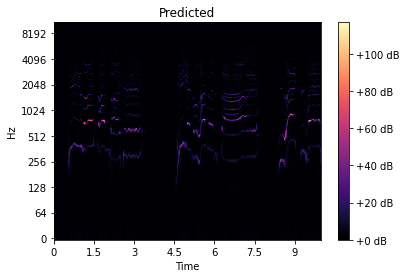

In [141]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vp), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")

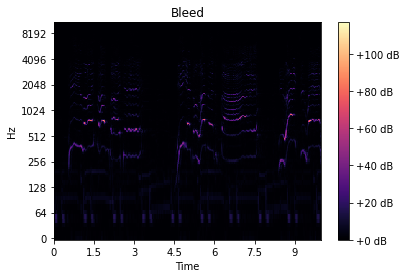

In [145]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_bv), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")

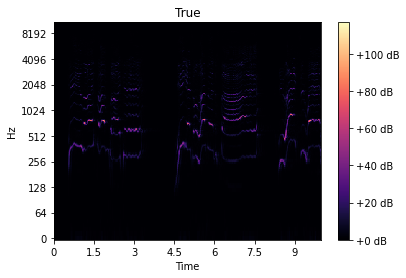

In [146]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_v), x_axis='time', y_axis='log', ax=ax)
ax.set(title='True')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [147]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [148]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [149]:
vocals[:clip].shape, S_pred[0].shape

((220500,), (220500,))

In [150]:
v_sdr = compute_sdr(vocals[:clip], S_pred[0], fs)
b_sdr = compute_sdr(bass[:clip], S_pred[1], fs)
d_sdr = compute_sdr(drums[:clip], S_pred[2], fs)
o_sdr = compute_sdr(other[:clip], S_pred[3], fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(50.456953711141594,
 51.16708858516446,
 49.97733358074448,
 53.13663149209134,
 47.54676118656609)